## Summary

---

## Imports

In [ ]:
from pathlib import Path

import numpy as np
import tqdm

import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import shap
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [182]:
pd.set_option("max_rows", 1000)
pd.set_option("max_columns", 1000)

## Parameters

In [183]:
NOTEBOOK_NAME = "bayesian-linear-regression"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_NAME

'bayesian-linear-regression'

## Load data

In [4]:
input_df = pq.read_table("01_prepare_combined_dataset/combined.parquet").to_pandas()

In [5]:
# input_df = pq.read_table("data-challenge/data_final2.parquet").to_pandas()

## Filter data

In [6]:
input_df["y"] = (
    (input_df[["acq2", "acq3", "acq4", "acq5"]].mean(axis=1) - input_df["acq"]) < -1
)

In [7]:
input_df = input_df[input_df["y"].notnull()]
input_df = input_df[
    (input_df[["acq", "acq2", "acq3", "acq4", "acq5"]] <= 6).all(axis=1)
]

In [8]:
assert len(input_df) == 143, len(input_df)

## Explore input data

In [9]:
# fg, ax = plt.subplots(figsize=(5, 4))
# ax.hist(input_df["y"], bins=20)
# ax.set_xlabel("Change in ACQ")
# ax.set_ylabel("Number of participants")
# None

In [10]:
input_df.columns

Index(['id', 'date_x', 'acq', 'date2', 'acq2', 'date3', 'acq3', 'date4',
       'acq4', 'date5', 'acq5', 'co-copd', 'co-heartfailure', 'co-diabetes',
       'co-yellowfever', 'co-asthma', 'co-pulmonaryembolism', 'co-bronchitis',
       'co-arthritis', 'co-pneumonia', 'medhistory_table', 'assess', 'smoking',
       'polyps', 'vaccine', 'arthritis', 'CVD', 'Prev-biologic', 'allergy',
       'weight', 'height', 'bmi', 'age', 'race', 'gender', 'work', 'retire',
       'disab', 'demographics_table', 'sex', 'date_y', 'clinic', 'infconsent',
       '18+', 'eos300', 'eos150', 'sputum', 'acq-screen', 'result', 'y'],
      dtype='object')

In [11]:
def compute_correlations(df, target_col):
    corrs = []
    for col in df._get_numeric_data():
        if col == target_col:
            continue
        df_subset = df[[col, target_col]].dropna()
        corr = stats.spearmanr(df_subset[col], df_subset[target_col])
        corrs.append((target_col, col) + tuple(corr))
    df = pd.DataFrame(corrs, columns=["col1", "col2", "corr", "pvalue"])
    df = df.sort_values("pvalue", ascending=True)
    return df

In [12]:
compute_correlations(input_df, 'y')

/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,col1,col2,corr,pvalue
5,y,acq5,-0.577211,4.490351e-14
4,y,acq4,-0.559940,3.578274e-13
3,y,acq3,-0.542856,2.486233e-12
2,y,acq2,-0.531933,8.117820e-12
1,y,acq,0.419604,1.823313e-07
27,y,age,0.201728,1.569026e-02
30,y,retire,0.266297,2.375572e-02
34,y,clinic,0.143913,8.638430e-02
33,y,sex,0.155447,8.865467e-02
0,y,id,0.140839,9.338890e-02


## Fit model

In [13]:
def encode_categorical(df, column):
    categories = {c: i for i, c in enumerate(set(df[column]))}
    df[column] = df[column].map(categories)

In [14]:
def iter_grid_params(grid_params):
    if not grid_params:
        return [{}]
    grid_params = grid_params.copy()
    key, values = grid_params.popitem()
    result = []
    for child_dict in iter_grid_params(grid_params):
        for value in values:
            result.append({**child_dict, key: value})
    return result

In [15]:
columns_to_drop = [
    #
    "id",
    "date_x",
    "date_y",
    "acq",
    "date2",
    "acq2",
    "date3",
    "acq3",
    "date4",
    "acq4",
    "date5",
    "acq5",
    "assess",
    "date_x",
    "date_y",
    "clinic",
    "infconsent",
    "18+",
    #     "eos300",
    "eos150",
    "sputum",
    "acq-screen",
    "result",
]
data_df = input_df.drop(pd.Index(columns_to_drop), axis=1)

In [16]:
# columns_to_keep = [
#     "y", "retire", "arthritis", "vaccine",
# ]
# data_df = data_df[columns_to_keep]

In [17]:
categorical_feature=[
    "medhistory_table",
    "race",
    "ethnicity",
    "work",
    "disab",
    "demographics_tabl",
    "clinic",
    "infconsent",
    "18+",
    "result",
]
categorical_feature = [c for c in categorical_feature if c in data_df]
for column in categorical_feature:
    encode_categorical(data_df, column)
    
categorical_feature

['medhistory_table', 'race', 'work', 'disab']

### Prepare LGB datasets

In [18]:
data_df.columns

Index(['co-copd', 'co-heartfailure', 'co-diabetes', 'co-yellowfever',
       'co-asthma', 'co-pulmonaryembolism', 'co-bronchitis', 'co-arthritis',
       'co-pneumonia', 'medhistory_table', 'smoking', 'polyps', 'vaccine',
       'arthritis', 'CVD', 'Prev-biologic', 'allergy', 'weight', 'height',
       'bmi', 'age', 'race', 'gender', 'work', 'retire', 'disab',
       'demographics_table', 'sex', 'eos300', 'y'],
      dtype='object')

In [19]:
lgb_train_test_splits = []

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(data_df, data_df["y"]):
    train_df = data_df.iloc[train_index]
    test_df = data_df.iloc[test_index]
    X_train = train_df.drop("y", axis=1)
    y_train = train_df["y"]
    X_test = test_df.drop("y", axis=1)
    y_test = test_df["y"]
    lgb_train = lgb.Dataset(
        X_train, y_train, categorical_feature=categorical_feature, free_raw_data=False
    )
    lgb_test = lgb.Dataset(
        X_test,
        y_test,
        reference=lgb_train,
        categorical_feature=categorical_feature,
        free_raw_data=False,
    )
    lgb_train_test_splits.append((lgb_train, lgb_test))

lgb_full = lgb.Dataset(
    data_df.drop("y", axis=1),
    data_df["y"],
    categorical_feature=categorical_feature,
    free_raw_data=False,
)

### Run grid-search

In [20]:
grid_params = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
#     'colsample_bytree' : [0.65, 0.66, 0.8],
#     'max_bin': [512],
#     'max_depth': [0, 2, 4, 8],
#     'min_split_gain': [0.5],
#     'min_child_weight': [1],
#     'min_child_samples': [5],
    #: "For small datasets, using small num_leaves is recommended"
    'num_leaves': [2, 4, 6, 8, 12, 16, 24, 32],
#     'num_class' : [1],
    'num_iterations': [5, 10, 20, 50, 100, 200],
#     'reg_alpha' : [1, 1.2],
#     'reg_lambda' : [1, 1.2, 1.4],
#     'subsample_for_bin': [200],
#     'subsample' : [0.8, 1],
#     'subsample_freq': [1],
#     'scale_pos_weight': [1],
    "min_sum_hessian_in_leaf": [0],
    "min_data_in_leaf": [1, 5, 10, 20],
    "max_bin": [15, 31, 63, 123, 255],
}

In [21]:
default_params = {
    "random_state": 42,
    "objective": "binary",
    "metric" : ["binary", "binary_error"],
    "is_unbalance": True,
#     'nthread': 3,
}

In [337]:
training_stats = []

for params in tqdm.tqdm_notebook(iter_grid_params(grid_params)):
    params = {**default_params, **params}
    stats = {
        "best_binary_logloss_train": [],
        "best_error_train": [],
        "best_binary_logloss_valid": [],
        "best_error_valid": [],
    }
    for lgb_train, lgb_test in lgb_train_test_splits:
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            early_stopping_rounds=None,
            verbose_eval=0,
        )
        stats["best_binary_logloss_train"].append(
            gbm.best_score["training"]["binary_logloss"]
        )
        stats["best_error_train"].append(gbm.best_score["training"]["binary_error"])
        stats["best_binary_logloss_valid"].append(
            gbm.best_score["valid_1"]["binary_logloss"]
        )
        stats["best_error_valid"].append(gbm.best_score["valid_1"]["binary_error"])
    training_stats.append(
        {
            **{k: np.mean(v) for k, v in stats.items()},
            "params": {**default_params, **params},
        }
    )

/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


KeyboardInterrupt: 

In [137]:
training_stats_df = pd.DataFrame(training_stats).sort_values("best_score_valid_l1", ascending=True)

In [138]:
training_stats_df.head(5)

,best_score_training_l1,best_score_training_l2,best_score_valid_l1,best_score_valid_l2,params
1928,0.63541,0.311559,0.669765,0.385595,"{'random_state': 42, 'objective': 'binary', 'm..."
1856,0.63541,0.311559,0.669765,0.385595,"{'random_state': 42, 'objective': 'binary', 'm..."
1910,0.63541,0.311559,0.669765,0.385595,"{'random_state': 42, 'objective': 'binary', 'm..."
1874,0.63541,0.311559,0.669765,0.385595,"{'random_state': 42, 'objective': 'binary', 'm..."
1892,0.63541,0.311559,0.669765,0.385595,"{'random_state': 42, 'objective': 'binary', 'm..."


In [139]:
df = pd.DataFrame(training_stats_df["params"].tolist())

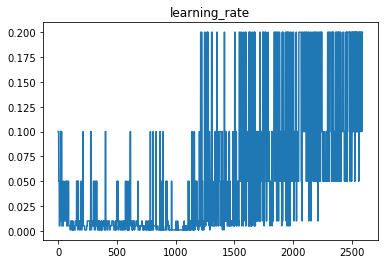

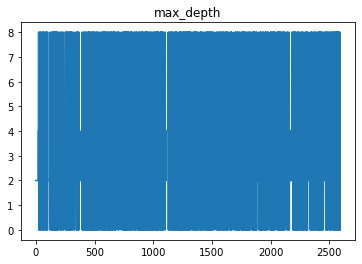

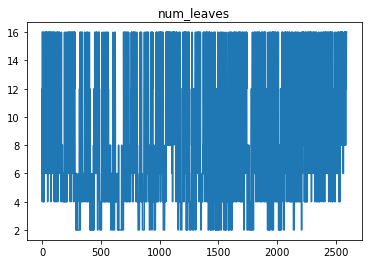

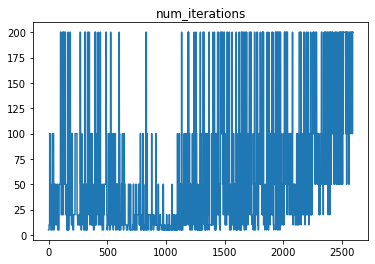

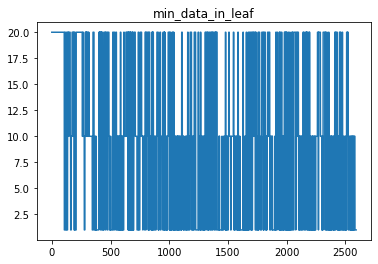

In [140]:
for key in df:
    if isinstance(df[key][0], list):
        continue
    if len(df[key].drop_duplicates()) == 1:
        continue
    plt.plot(df[key])
    plt.title(key)
    plt.show()

### Train best model

In [338]:
best_params = training_stats_df.iloc[0]["params"].copy()

In [339]:
gbm = lgb.train(best_params, lgb_full, valid_sets=[lgb_full], verbose_eval=0)

In [340]:
gbm.best_score

defaultdict(dict,
            {'training': {'binary_error': 0.3006993006993007,
              'binary_logloss': 0.6392947951695244}})

In [341]:
gbm.num_trees()

5

In [145]:
data_df_copy = data_df.copy()
for c in data_df_copy:
    if c not in ["age", "retire"]:
        data_df_copy[c] = 0
        
gbm.predict(data_df) == gbm.predict(data_df_copy)

array([ True, False, False, False,  True,  True, False, False, False,
       False,  True, False, False,  True,  True, False, False, False,
        True,  True,  True, False,  True,  True,  True,  True, False,
       False, False,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
        True,  True, False,  True, False,  True,  True,  True, False,
        True, False, False, False,  True,  True,  True, False, False,
        True, False, False, False, False,  True, False,  True, False,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False, False,

In [146]:
gbm.feature_importance()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 5, 0,
       0, 0, 2, 0, 0, 0, 0])

## Analyze best model

### Feature importances

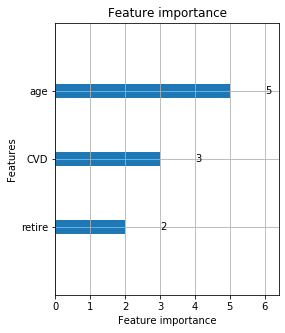

In [328]:
fg, ax = plt.subplots(figsize=(4, 5))
lgb.plot_importance(gbm, ax=ax)
ax.set_xlim(0, 6.4)
fg.savefig(NOTEBOOK_PATH / "feature-importance.svg", bbox_inches="tight")

### Cross-validation accuracy

In [330]:
actual = []
predicted = []

for lgb_train, lgb_test in lgb_train_test_splits:
    gbm_sub = lgb.train(
        best_params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        early_stopping_rounds=None,
        verbose_eval=0,
    )
    print(gbm_sub.feature_importance())
    actual.append(lgb_test.label)
    predicted.append(gbm_sub.predict(lgb_test.data))
    
actual = np.hstack(actual)
predicted = np.hstack(predicted)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 5 0 0 0 3 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 3 0 0 0 1 0 5 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 0 0 0 1 0 5 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 5 0 0 0 3 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 5 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 5 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 5 0 0 0 3 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 5 0 0 0 2 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 5 0 0 0 2 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 1 5 0 0 0 2 0 0 0 0]


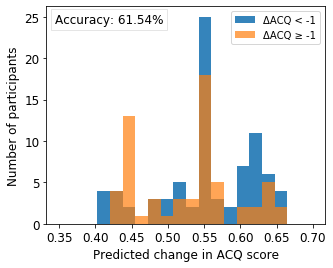

In [342]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(5, 4))

accuracy = (actual == (predicted > 0.5)).sum() / len(predicted)
textstr = f"Accuracy: {accuracy:.2%}"
ax.text(
    0.03,
    0.97,
    textstr,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.1),
)

ax.set_xlabel("Predicted change in ACQ score")
ax.set_ylabel("Number of participants")
xlim = (0.35, 0.7)
assert predicted.min() > xlim[0] and predicted.max() < xlim[1]
ax.hist(predicted[actual], bins=20, range=xlim, label="ΔACQ < -1", alpha=0.9)
ax.hist(predicted[~actual], bins=20, range=xlim, label="ΔACQ ≥ -1", alpha=0.7)
ax.legend()
fg.savefig(NOTEBOOK_PATH / "model-accuracy.svg", bbox_inches="tight")

### Plot ROC curve

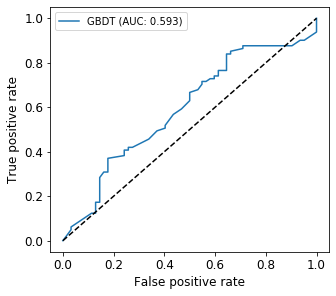

In [332]:
with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(5, 4.5))

fpr_rt_lm, tpr_rt_lm, _ = metrics.roc_curve(actual, predicted)
ax.plot(
    fpr_rt_lm,
    tpr_rt_lm,
    label=f"GBDT (AUC: {metrics.roc_auc_score(actual, predicted):.3f})",
)
ax.plot(fpr_rt_lm, fpr_rt_lm, "k--")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend()
fg.savefig(NOTEBOOK_PATH / "model-roc.svg", bbox_inches="tight")

### Partial dependence plots

In [333]:
X = data_df.drop("y", axis=1)
mask = gbm.feature_importance() > 0

In [334]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)

/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


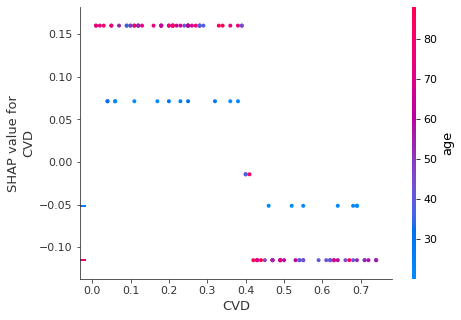

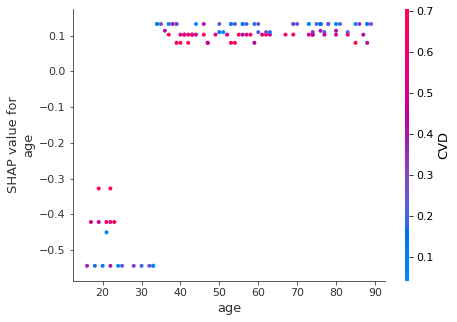

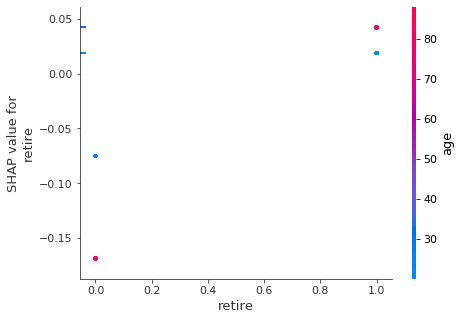

In [335]:
for col in X.loc[:, gbm.feature_importance() > 0].columns:
    fg, ax = plt.subplots(figsize=(7, 5))
    shap.dependence_plot(col, shap_values[1], X, X.columns, ax=ax)
    fg.savefig(NOTEBOOK_PATH / f"shap-{col}.svg", bbox_inches="tight")

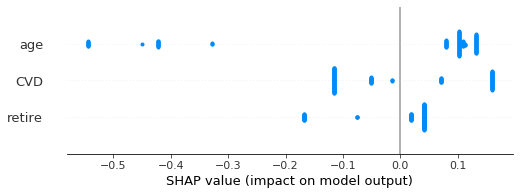

In [336]:
shap.summary_plot(np.vstack([v[mask] for v in shap_values[1]]), X.loc[:, mask].columns)